# Lab1 — PyTorch Foundations for Computer Vision

**Course**: Deep Learning for Image Analysis 

**Class**: M2 IASD App  

**Professor**: Mehyar MLAWEH

---

## Objectives
By the end of this lab, you should be able to:

- Understand how **neurons and layers** are implemented in PyTorch
- Manipulate **tensors** and reason about shapes
- Use **autograd** to compute gradients
- Implement a **training loop** yourself
- Connect theory (neurons, loss, backprop) to actual code

⚠️ This notebook is **intentionally incomplete**.  
Whenever you see **`# TODO`**, you are expected to write code.


**Deadline:** 🗓️ **Saturday, February 7th (23:59)**

## 🤖 A small (honest) note before you start

Let’s be real for a second.

 I know you **can use LLMs (ChatGPT, Copilot, Claude, etc.)** to help you with this lab.  
And yes, **I use them too**, so don’t worry 😄

👉 **You are allowed to use AI tools.**  
But here’s the deal:

- Don’t just **copy–paste** code you don’t understand  
- Take time to **read, question, and modify** what the model gives you  
- If you can solve a block **by yourself, without AI**, that’s excellent 

Remember:

> AI can write code for you, but **only you can understand it** — and understanding is what matters for exams, projects, and real work.

Use these tools **as assistants, not as replacements for thinking**.

---

## 📚 Useful documentation (highly recommended)

You will often find answers faster (and more reliably) by checking the official documentation:

- **PyTorch main documentation**  
  https://pytorch.org/docs/stable/index.html

- **PyTorch tensors**  
  https://pytorch.org/docs/stable/tensors.html

- **Neural network modules (`torch.nn`)**  
  https://pytorch.org/docs/stable/nn.html

- **Loss functions** (`BCEWithLogitsLoss`, CrossEntropy, etc.)  
  https://pytorch.org/docs/stable/nn.html#loss-functions

- **Optimizers** (`SGD`, `Adam`, …)  
  https://pytorch.org/docs/stable/optim.html

If you learn how to **navigate the documentation**, you are already thinking like a real AI engineer 👌

---

## PART I

## 0) Colab setup — GPU check

**Instructions**
1. In Colab: `Runtime → Change runtime type to GPU T4` 
2. Select **GPU**
3. Save and restart runtime

Then run the cell below.


In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# TODO: set the device correctly (cuda if available, else cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)


PyTorch version: 2.9.0+cu126
CUDA available: True
Using device: cuda


## 1) Imports and reproducibility


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# TODO: fix the random seed for reproducibility
# torch.manual_seed(...)
torch.manual_seed(42)
import numpy as np

## 2) PyTorch tensors and shapes

Tensors are multi-dimensional arrays that support:
- GPU acceleration
- automatic differentiation

Understanding **shapes** is critical in deep learning.


In [3]:
# Examples
a = torch.tensor([1.0, 2.0, 3.0])
b = torch.randn(4, 5)

print("a shape:", a.shape)
print("b shape:", b.shape)


a shape: torch.Size([3])
b shape: torch.Size([4, 5])


### 🔍 Question (answer inside the markdown)
- How many dimensions does tensor `b` have?
- What does each dimension represent conceptually?

>### Answer:
>- Tensor `b` has 2 dimensions.
>- In principle, the first dimension represents the number of samples (lines), and the second dimension represents the features of each sample (columns).

### ✅Tensor operations

Complete the following:

1. Create a tensor `x` of shape `(8, 3)` with random values  
2. Compute:
   - the **mean of each column**
   - the **L2 norm of each row**
3. Normalize `x` **row-wise** using the L2 norm

In [4]:
# TODO: create x
x = torch.randn(8, 3)


# TODO: column mean
col_mean = torch.mean(x, dim=0)

# TODO: row-wise L2 norm
row_norm = torch.norm(x, p=2, dim=1, keepdim=True)

# TODO: normalized tensor
x_normalized = x / row_norm

print(x.shape, col_mean.shape, row_norm.shape, x_normalized.shape)


torch.Size([8, 3]) torch.Size([3]) torch.Size([8, 1]) torch.Size([8, 3])


## 3) Artificial neuron — from math to code

A neuron computes:

$$
z = \sum_i w_i x_i + b
$$

Then applies an activation function:

$$
y = g(z)
$$

This section connects directly to the theory seen in class.


In [5]:
x = torch.tensor([1.0, -2.0, 3.0])
w = torch.tensor([0.2, 0.4, -0.1])
b = torch.tensor(0.1)

z = torch.sum(x * w) + b
z


tensor(-0.8000)

### Activation functions

1. Implement **ReLU**
2. Implement **Sigmoid**
3. Apply both to `z` and compare the outputs

Which activation preserves negative values?


In [6]:
# TODO
def relu(z):
    return torch.maximum(torch.tensor(0.0), z)

def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

y_relu = relu(x)
y_sigmoid = sigmoid(x)
print("ReLU:", y_relu)
print("Sigmoid:", y_sigmoid)


ReLU: tensor([1., 0., 3.])
Sigmoid: tensor([0.7311, 0.1192, 0.9526])


## 4) Autograd and gradients

PyTorch uses **automatic differentiation** to compute gradients
using the **chain rule** (backpropagation).


In [7]:
x = torch.tensor([1.0, 2.0, -1.0], requires_grad=True)
w = torch.tensor([0.5, -0.3, 0.8], requires_grad=True)
b = torch.tensor(0.2, requires_grad=True)

z = torch.sum(x * w) + b
loss = (z - 1.0) ** 2

loss.backward()

print("loss:", loss.item())
print("grad w:", w.grad)
print("grad b:", b.grad)


loss: 2.890000104904175
grad w: tensor([-3.4000, -6.8000,  3.4000])
grad b: tensor(-3.4000)


### 🔍 Conceptual question

- If `b.grad > 0`, should `b` increase or decrease after a gradient descent step?
Explain **why** in one sentence.

>### Answer:
>If `b.grad > 0`, `b` should decrease after a gradient descent step because the positive gradient indicates that increasing `b` would increase the loss, so to minimize the loss, we need to move `b` in the opposite direction of the gradient.


## 5) Toy classification dataset

We create a **linearly separable** dataset.

Label rule:
- class = 1 if `x₁ + x₂ + x₃ > 0`
- else class = 0

This mimics a very simple classification problem.


In [8]:
# TODO: generate a dataset of size N=500 with 3 features
X = torch.randn(500, 3)
y = (X.sum(dim=1, keepdim=True) > 0).float()

# TODO: split into train (80%) and validation (20%)
train_size = int(0.8 * X.size(0))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: torch.Size([400, 3])
X_val shape: torch.Size([100, 3])
y_train shape: torch.Size([400, 1])
y_val shape: torch.Size([100, 1])


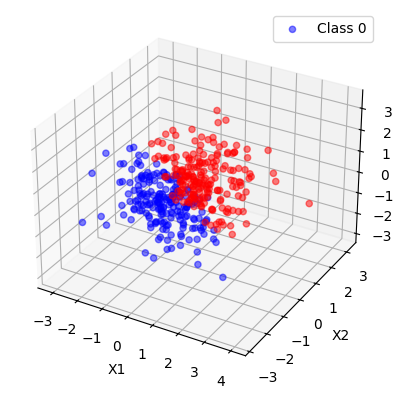

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train[:, 0], cmap='bwr', alpha=0.5)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.legend(['Class 0', 'Class 1'])
plt.show()


## 6) Model definition

We define a small **MLP** (fully-connected network):

`3 → 16 → 8 → 1`

Activation: ReLU  
Output: raw logits (no sigmoid)


In [9]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.ReLU(),
            nn.Linear(8, 1),
        )

    def forward(self, x):
        return self.net(x)

# TODO: create model and move it to the GPU 
model = MLP().to(device)


###  parameters

1. Compute **by hand** the total number of parameters
2. Verify your answer using PyTorch


In [10]:
# TODO: count parameters with PyTorch and manually
total_params_torch  = sum(p.numel() for p in model.parameters())

# Manually count parameters
total_params_manual = 3 * 16 + 16 * 8 + 8 * 1 + 16 + 8 * 1 + 1  # weights + biases

print("Total parameters (PyTorch):", total_params_torch)
print("Total parameters (Manual):", total_params_manual)

Total parameters (PyTorch): 209
Total parameters (Manual): 209


## 7) Training loop 

You must complete the full training loop:
- forward pass
- loss computation
- backward pass
- optimizer step

Loss: `BCEWithLogitsLoss`
Optimizer: `SGD`


In [11]:
# TODO: move data to device
X_train_d = X_train.to(device)
y_train_d = y_train.to(device)
X_val_d = X_val.to(device)
y_val_d = y_val.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(50):
    model.train()
    optimizer.zero_grad()

    # TODO: forward
    logits = model(X_train_d)

    # TODO: loss
    loss = criterion(logits, y_train_d)

    # TODO: backward
    loss.backward()

    # TODO: update
    optimizer.step()

    if epoch % 5 == 0:
        print("Epoch", epoch, "| loss =", float(loss))


Epoch 0 | loss = 0.7006815671920776
Epoch 5 | loss = 0.6826688051223755
Epoch 10 | loss = 0.6627987623214722
Epoch 15 | loss = 0.6406792998313904
Epoch 20 | loss = 0.6144785284996033
Epoch 25 | loss = 0.5832680463790894
Epoch 30 | loss = 0.5466195344924927
Epoch 35 | loss = 0.5044291019439697
Epoch 40 | loss = 0.45812201499938965
Epoch 45 | loss = 0.4103253185749054


/tmp/ipython-input-3453927590.py:27: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print("Epoch", epoch, "| loss =", float(loss))


## 8) Evaluation

1. Apply `sigmoid` to the logits
2. Convert probabilities to predictions
3. Compute **accuracy** on the validation set


In [12]:
# TODO: evaluation
with torch.no_grad():
    logits = model(X_val_d)
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()

accuracy = (preds == y_val_d).float().mean().item()
print("Validation accuracy:", accuracy)


Validation accuracy: 0.9599999785423279


## 9) Reflection questions (answer inside the markdown)

1. Why do we **not** apply sigmoid inside the model?
2. What would happen if we removed all ReLU activations?
3. How does this toy problem relate to image classification?

Write short answers (2–3 lines each).

>### Answers:
>1. We do not apply sigmoid inside the model because `BCEWithLogitsLoss` combines the sigmoid activation and `binary cross-entropy loss` in a numerically stable way, which improves training performance.
>2. If we removed all ReLU activations, the model would become a linear model which could lead to poor performance on non-linear tasks.
>3. Involve learning to map input features (pixels in images) to output classes, requiring the model to capture patterns and relationships in the data.


## 10) Bridge to Computer Vision

So far:
- inputs = vectors of size 3
- layers = fully-connected

Next session:
- inputs = images `(B, C, H, W)`
- layers = convolutions
- same training logic

👉 **Architecture changes, learning principles stay the same.**


## Part II — Training on MNIST

Check the next notebook